# ДЗ №1
## Описание задачи.

Автомобильная компания планирует выйти на новые рынки со своими существующими продуктами. После интенсивного маркетингового исследования, они пришли к выводу, что поведение нового рынка аналогично их существующему рынку.

На своем существующем рынке, команда продаж разделила всех клиентов на 4 сегмента (A, B, C, D). Затем они провели сегментированный охват и коммуникацию для различных сегментов клиентов. Эта стратегия отлично себя зарекомендовала, и они планируют использовать ту же стратегию на новых рынках.

Вам необходимо помочь менеджеру предсказать правильную группу новых клиентов.

### Описание признаков
<p>ID | Уникальный идентификатор
<p>Gender | Пол клиента
<p>Ever_Married | Семейное положение клиента
<p>Age | Возраст клиента
<p>Graduated | Получил ли клиент образование
<p>Profession | Профессия клиента
<p>Work_Experience | Опыт работы в годах
<p>Spending_Score | Балл трат клиента
<p>Family_Size | Количество членов семьи клиента (включая самого клиента)
<p>Val_1 | Анонимная категория для клиента
<p>Segmentation | (Целевая) категория клиентов

In [1339]:
import pandas as pd
import scipy as sp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from lightgbm                         import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import accuracy_score, confusion_matrix

## П-1 Прочитать данные

In [1340]:
data = pd.read_csv("/content/Train.csv")

In [1341]:
data

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A
...,...,...,...,...,...,...,...,...,...,...,...
8063,464018,Male,No,22,No,NaN,0.0,Low,7.0,Cat_1,D
8064,464685,Male,No,35,No,Executive,3.0,Low,4.0,Cat_4,D
8065,465406,Female,No,33,Yes,Healthcare,1.0,Low,1.0,Cat_6,D
8066,467299,Female,No,27,Yes,Healthcare,1.0,Low,4.0,Cat_6,B


In [1342]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


Видно, что почти во всех столбцах есть пропуски.

## П-2 Вычислить основные характеристики

In [1343]:
data.describe()

,ID,Age,Work_Experience,Family_Size
count,8068.000000,8068.000000,7239.000000,7733.000000
mean,463479.214551,43.466906,2.641663,2.850123
std,2595.381232,16.711696,3.406763,1.531413
min,458982.000000,18.000000,0.000000,1.000000
25%,461240.750000,30.000000,0.000000,2.000000
50%,463472.500000,40.000000,1.000000,3.000000
75%,465744.250000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


Сразу же заполним пропуски в числовых признаках медианным значением.

In [1344]:
data['Work_Experience'].fillna(data['Work_Experience'].median(), inplace=True)
data['Family_Size'].fillna(data['Family_Size'].median(), inplace=True)

Преобразование объектных признаков в категориальные.

In [1345]:
data["Gender"] = data["Gender"].astype("category")
data["Ever_Married"] = data["Ever_Married"].astype("category")
data["Graduated"] = data["Graduated"].astype("category")
data["Profession"] = data["Profession"].astype("category")
data["Spending_Score"] = data["Spending_Score"].astype("category")
data["Var_1"] = data["Var_1"].astype("category")
data["Segmentation"] = data["Segmentation"].astype("category")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   ID               8068 non-null   int64   
 1   Gender           8068 non-null   category
 2   Ever_Married     7928 non-null   category
 3   Age              8068 non-null   int64   
 4   Graduated        7990 non-null   category
 5   Profession       7944 non-null   category
 6   Work_Experience  8068 non-null   float64 
 7   Spending_Score   8068 non-null   category
 8   Family_Size      8068 non-null   float64 
 9   Var_1            7992 non-null   category
 10  Segmentation     8068 non-null   category
dtypes: category(7), float64(2), int64(2)
memory usage: 308.8 KB


In [1346]:
data["Gender"].dtype, data["Ever_Married"].dtype, data["Graduated"].dtype, data["Profession"].dtype, data["Spending_Score"].dtype, data["Var_1"].dtype, data["Segmentation"].dtype

(CategoricalDtype(categories=['Female', 'Male'], ordered=False, categories_dtype=object),
 CategoricalDtype(categories=['No', 'Yes'], ordered=False, categories_dtype=object),
 CategoricalDtype(categories=['No', 'Yes'], ordered=False, categories_dtype=object),
 CategoricalDtype(categories=['Artist', 'Doctor', 'Engineer', 'Entertainment', 'Executive',
                   'Healthcare', 'Homemaker', 'Lawyer', 'Marketing'],
 , ordered=False, categories_dtype=object),
 CategoricalDtype(categories=['Average', 'High', 'Low'], ordered=False, categories_dtype=object),
 CategoricalDtype(categories=['Cat_1', 'Cat_2', 'Cat_3', 'Cat_4', 'Cat_5', 'Cat_6',
                   'Cat_7'],
 , ordered=False, categories_dtype=object),
 CategoricalDtype(categories=['A', 'B', 'C', 'D'], ordered=False, categories_dtype=object))

Заполним пропуски в категориальных признаках самым частовстречающимся значением, так как таких пропусков было немного, это решение не должно сильно повлиять на ошибку классификации.

In [1347]:
data['Ever_Married'].fillna(data['Ever_Married'].value_counts().idxmax(), inplace=True)
data['Graduated'].fillna(data['Graduated'].value_counts().idxmax(), inplace=True)
data['Profession'].fillna(data['Profession'].value_counts().idxmax(), inplace=True)
data['Var_1'].fillna(data['Var_1'].value_counts().idxmax(), inplace=True)

In [1348]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   ID               8068 non-null   int64   
 1   Gender           8068 non-null   category
 2   Ever_Married     8068 non-null   category
 3   Age              8068 non-null   int64   
 4   Graduated        8068 non-null   category
 5   Profession       8068 non-null   category
 6   Work_Experience  8068 non-null   float64 
 7   Spending_Score   8068 non-null   category
 8   Family_Size      8068 non-null   float64 
 9   Var_1            8068 non-null   category
 10  Segmentation     8068 non-null   category
dtypes: category(7), float64(2), int64(2)
memory usage: 308.8 KB


Описание чистовых данных и их квадратичное отклонение, среднее, минимум, максимум:

In [1349]:
data.describe()

,ID,Age,Work_Experience,Family_Size
count,8068.000000,8068.000000,8068.000000,8068.000000
mean,463479.214551,43.466906,2.472980,2.856346
std,2595.381232,16.711696,3.265248,1.499577
min,458982.000000,18.000000,0.000000,1.000000
25%,461240.750000,30.000000,0.000000,2.000000
50%,463472.500000,40.000000,1.000000,3.000000
75%,465744.250000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


Описание категориальных признаков:

In [1350]:
data.describe(include = ['category'])

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
count,8068,8068,8068,8068,8068,8068,8068
unique,2,2,2,9,3,7,4
top,Male,Yes,Yes,Artist,Low,Cat_6,D
freq,4417,4783,5046,2640,4878,5314,2268


Нужно удалить ID клиентов, так как это всего лишь его идентификатор, не влияющий на классификацию.

In [1351]:
data.drop(columns = 'ID', inplace = True)

## Визуализация данных


### Матрица корреляций

In [1352]:
data_corr = data.corr(numeric_only = True)
data_corr

,Age,Work_Experience,Family_Size
Age,1.000000,-0.177344,-0.273373
Work_Experience,-0.177344,1.000000,-0.059692
Family_Size,-0.273373,-0.059692,1.000000


<Axes: >

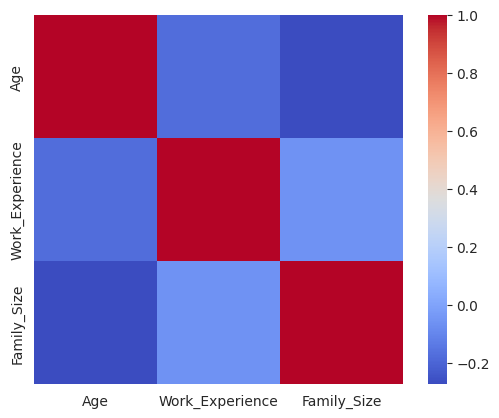

In [1353]:
sns.heatmap(data_corr, square = True, cmap = 'coolwarm')

По матрице видно, что между признаками в парах возраст - стаж и возраст - размер семьи существует корреляция, что логично

Гистограммы числовых данных:

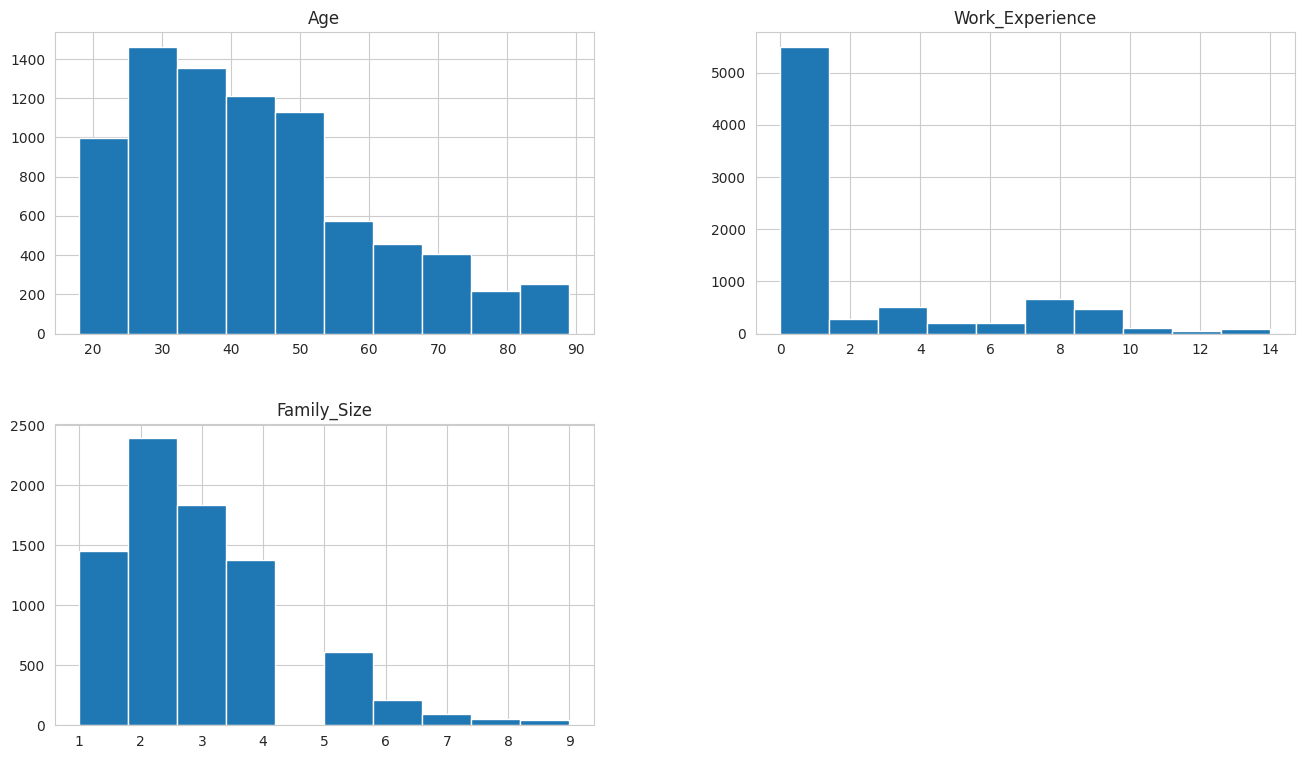

In [1354]:
sns.set_style('whitegrid')
numbers = pd.Series(data.columns)
data[numbers].hist(figsize = (16, 9))
plt.show()

Гистограммы, визуализирующие зависимость категориальных признаков от целевого сегмента:

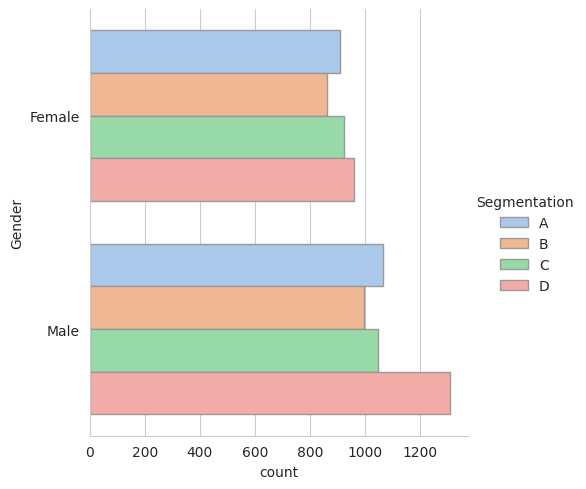

In [1355]:
sns.catplot(y = "Gender", hue = "Segmentation", kind = "count", palette = "pastel", edgecolor = ".6", data = data)

Небольшая взаимосвязь целевого сегмента и пола.

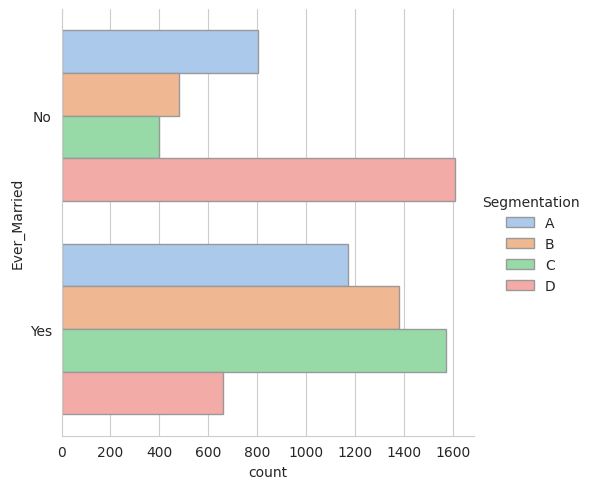

In [1356]:
sns.catplot(y = "Ever_Married", hue = "Segmentation", kind = "count", palette = "pastel", edgecolor = ".6", data = data)

Люди не состоящие в браке попадают в основном в D категорию.

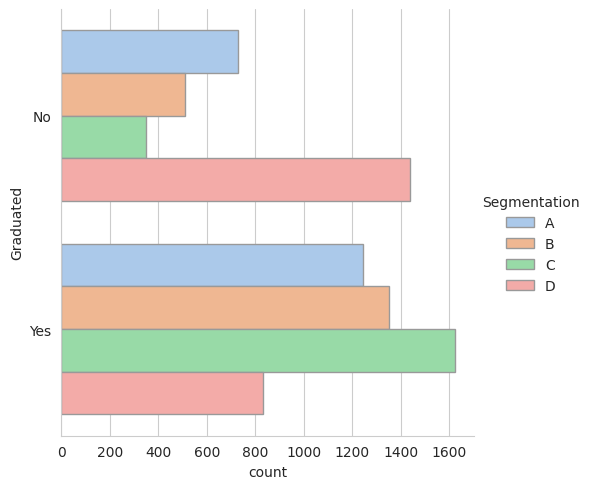

In [1357]:
sns.catplot(y = "Graduated", hue = "Segmentation", kind = "count", palette = "pastel", edgecolor = ".6", data = data)

Люди не получившие образование попадают в основном в D категорию.

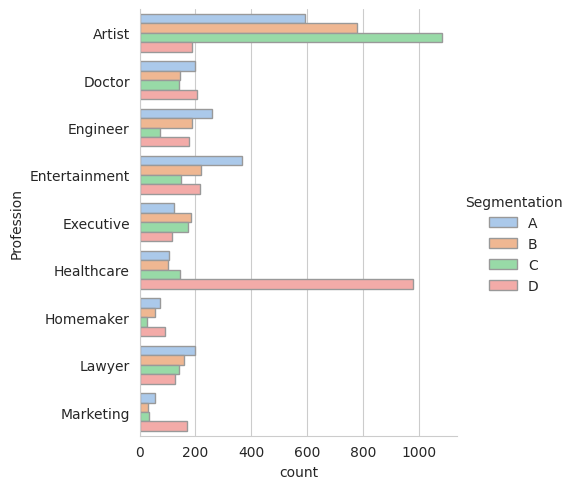

In [1358]:
sns.catplot(y = "Profession", hue = "Segmentation", kind = "count", palette = "pastel", edgecolor = ".6", data = data)

Есть зависимость сегмента от профессии.

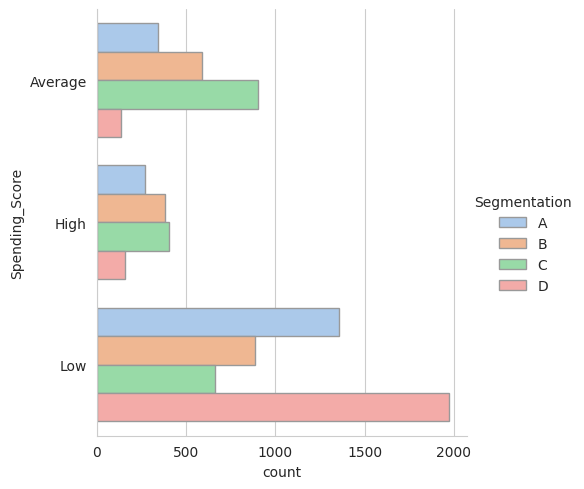

In [1359]:
sns.catplot(y = "Spending_Score", hue = "Segmentation", kind = "count", palette = "pastel", edgecolor = ".6", data = data)

Есть зависимость сегмента от регулярных трат.

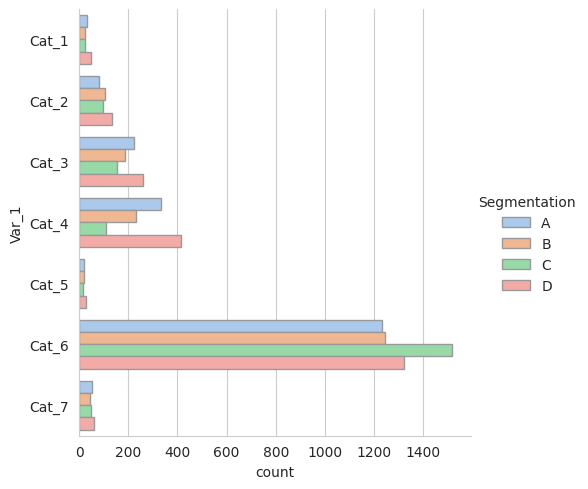

In [1360]:
sns.catplot(y = "Var_1", hue = "Segmentation", kind = "count", palette = "pastel", edgecolor = ".6", data = data)

Относительно небольшая корреляция сегмента и анонимной категории клиента.

In [1361]:
numeric_cols = ["Age", "Work_Experience", "Family_Size"]
categorial_cols = ['Gender', "Ever_Married", "Profession", "Graduated", "Spending_Score", 'Var_1']

In [1362]:
data

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,Female,Yes,38,Yes,Engineer,1.0,Average,3.0,Cat_4,A
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,Female,Yes,40,Yes,Entertainment,1.0,High,6.0,Cat_6,A
...,...,...,...,...,...,...,...,...,...,...
8063,Male,No,22,No,Artist,0.0,Low,7.0,Cat_1,D
8064,Male,No,35,No,Executive,3.0,Low,4.0,Cat_4,D
8065,Female,No,33,Yes,Healthcare,1.0,Low,1.0,Cat_6,D
8066,Female,No,27,Yes,Healthcare,1.0,Low,4.0,Cat_6,B


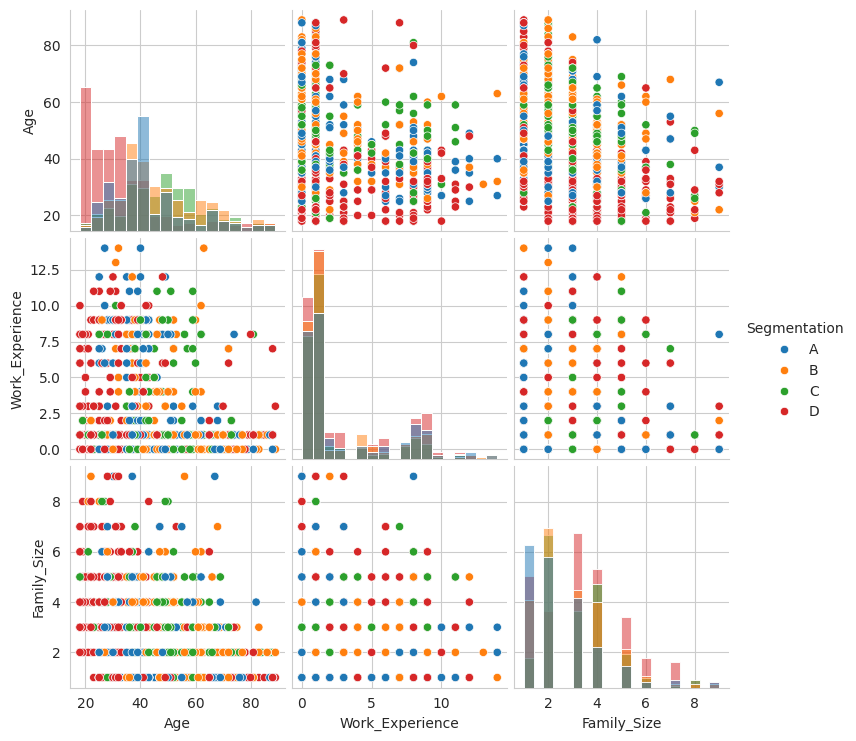

In [1363]:
sns.pairplot(data.iloc[np.random.choice(np.arange(data.shape[0]), size = 1000, replace = False)], hue = 'Segmentation', diag_kind = 'hist')

## П-4 Обработка категориальных признаков

In [1364]:
data.columns

Index(['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')

In [1365]:
# data1 = pd.get_dummies(data, columns = categorial_cols)
data1 = data

Присвоение каждому значению в категории своей метки с помощью кодировщика.

In [1366]:
from sklearn.preprocessing import LabelEncoder

for i in ['Gender' , 'Ever_Married' , 'Graduated','Profession','Spending_Score','Var_1'  ]:
    le = LabelEncoder()
    data1[i] = le.fit_transform(data1[i].astype('str'))

In [1367]:
data1.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,1,0,22,0,5,1.0,2,4.0,3,D
1,0,1,38,1,2,1.0,0,3.0,3,A
2,0,1,67,1,2,1.0,2,1.0,5,B
3,1,1,67,1,7,0.0,1,2.0,5,B
4,0,1,40,1,3,1.0,1,6.0,5,A


## П-5 Нормализация числовых значений

In [1368]:
minmaxscaler= MinMaxScaler()
data1['Age']  = minmaxscaler.fit_transform(np.array(data1['Age']).reshape(-1, 1))
data1['Work_Experience']  = minmaxscaler.fit_transform(np.array(data1['Work_Experience']).reshape(-1, 1))
data1['Family_Size']  = minmaxscaler.fit_transform(np.array(data1['Family_Size']).reshape(-1, 1))
data1

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,1,0,0.056338,0,5,0.071429,2,0.375,3,D
1,0,1,0.281690,1,2,0.071429,0,0.250,3,A
2,0,1,0.690141,1,2,0.071429,2,0.000,5,B
3,1,1,0.690141,1,7,0.000000,1,0.125,5,B
4,0,1,0.309859,1,3,0.071429,1,0.625,5,A
...,...,...,...,...,...,...,...,...,...,...
8063,1,0,0.056338,0,0,0.000000,2,0.750,0,D
8064,1,0,0.239437,0,4,0.214286,2,0.375,3,D
8065,0,0,0.211268,1,5,0.071429,2,0.000,5,D
8066,0,0,0.126761,1,5,0.071429,2,0.375,5,B


## П-6 Разделение данных на обучающую и тестовую выборки
Соотношение размеров обучающеи выборки к тестовой = 7 / 3

In [1369]:
y = data1['Segmentation']
x = data1.drop(['Segmentation'], axis = 1)

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size = 0.3, random_state = 42)

In [1370]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5647 entries, 5015 to 7270
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           5647 non-null   int64  
 1   Ever_Married     5647 non-null   int64  
 2   Age              5647 non-null   float64
 3   Graduated        5647 non-null   int64  
 4   Profession       5647 non-null   int64  
 5   Work_Experience  5647 non-null   float64
 6   Spending_Score   5647 non-null   int64  
 7   Family_Size      5647 non-null   float64
 8   Var_1            5647 non-null   int64  
dtypes: float64(3), int64(6)
memory usage: 441.2 KB


## П-7 Запуск KNN

In [1371]:
model = KNeighborsClassifier(n_neighbors = 1)
model.fit(x_train, y_train)
y_train_predict = model.predict(x_train)
y_test_predict  = model.predict(x_test)

print(np.mean(y_train != y_train_predict), np.mean(y_test != y_test_predict))
print(f'Accuracy Score train : {accuracy_score(y_train, y_train_predict)*100}')
print(f'Accuracy Score test : {accuracy_score(y_test, y_test_predict)*100}')

0.041615016823091905 0.5510119785212721
Accuracy Score train : 95.8384983176908
Accuracy Score test : 44.89880214787278


## П-8 Подбор гиперпараметра KNN с наименьшей ошибкой на тесте.

In [1372]:
neighbours = [1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 30]
errs_train = []
errs_test = []

for i in neighbours:
    model = KNeighborsClassifier(n_neighbors = i)
    model.fit(x_train, y_train)
    y_train_predict = model.predict(x_train)
    y_test_predict  = model.predict(x_test)
    errs_train.append(np.mean(y_train != y_train_predict))
    errs_test.append(np.mean(y_test != y_test_predict))

mat = pd.DataFrame([errs_train, errs_test], columns = neighbours,index=["errs_train", "errs_test"])
mat

,1,2,3,4,5,7,10,15,20,25,30
errs_train,0.041615,0.287586,0.319639,0.343368,0.367983,0.393306,0.410129,0.424827,0.441119,0.448911,0.453515
errs_test,0.551012,0.598513,0.532838,0.535316,0.529946,0.521685,0.515076,0.508055,0.503924,0.493598,0.495250


Лучший результат при n_neighbours = 25
Как оказалось, с такими данными обычный классификатор определяет правильный класс примерно в половине случаев.

# ДЗ №4

## П-1 Стандартизация входных данных.
Для этого используется StandartScaler из библиотеки scikit learn.

In [1390]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

## П-2 Создание и обучение моделей Kmeans, DBSCAN и аггломеративной кластеризации.
Для Kmeans и аггломеративной моделей задается количество кластеров - 4.

In [1405]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

dbscan = DBSCAN(eps=1.55, min_samples=6)
dbscan_labels = dbscan.fit_predict(X_scaled)

agglo = AgglomerativeClustering(n_clusters=4)
agglo_labels = agglo.fit_predict(X_scaled)

## П-3 Оценка ARI результата работы и подсчет силуэта каждой модели.

In [1406]:
ari_kmeans = adjusted_rand_score(y, kmeans_labels)
ari_dbscan = adjusted_rand_score(y, dbscan_labels)
ari_agglo = adjusted_rand_score(y, agglo_labels)

print(f"ARI for KMeans: {ari_kmeans:.4f}")
print(f"ARI for DBSCAN: {ari_dbscan:.4f}")
print(f"ARI for Agglomerative Clustering: {ari_agglo:.4f}")

ARI for KMeans: 0.1151
ARI for DBSCAN: 0.0642
ARI for Agglomerative Clustering: 0.0644


In [1394]:
dbscan_labels_filtered = dbscan_labels[dbscan_labels != -1]
X_scaled_filtered = X_scaled[dbscan_labels != -1]

silhouette_kmeans = silhouette_score(X_scaled, kmeans_labels)
silhouette_dbscan = silhouette_score(X_scaled_filtered, dbscan_labels_filtered)
silhouette_agglo = silhouette_score(X_scaled, agglo_labels)

print(f"Silhouette Score for KMeans: {silhouette_kmeans:.4f}")
print(f"Silhouette Score for DBSCAN: {silhouette_dbscan:.4f}")
print(f"Silhouette Score for Agglomerative Clustering: {silhouette_agglo:.4f}")

Silhouette Score for KMeans: 0.1860
Silhouette Score for DBSCAN: 0.1525
Silhouette Score for Agglomerative Clustering: 0.1506


## П-4 Визуализация спроектированных на плоскость методом главных компонент кластеров.

In [1391]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

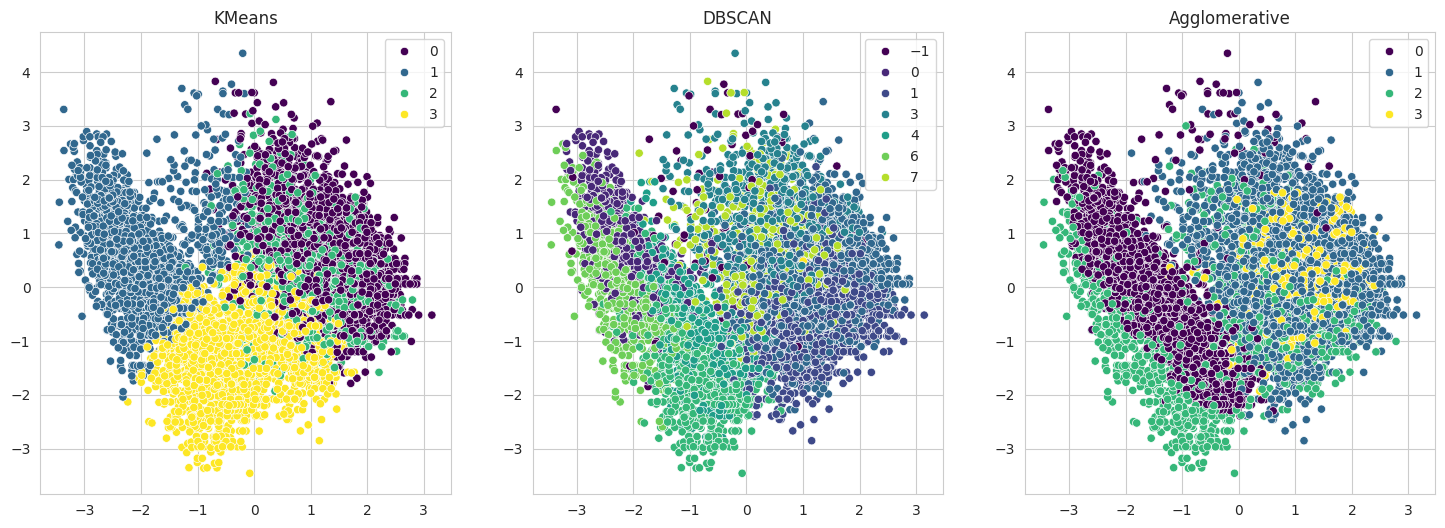

In [1395]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette="viridis", ax=axs[0])
axs[0].set_title("KMeans")

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=dbscan_labels, palette="viridis", ax=axs[1])
axs[1].set_title("DBSCAN")

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=agglo_labels, palette="viridis", ax=axs[2])
axs[2].set_title("Agglomerative")

plt.show()